# How to stream from subgraphs

If you have created a graph with subgraphs you may wish to stream things occurring inside those subgraphs (or you may not!). This guide will walk through how you can control the information that is streamed back from subgraphs.

## Setup

First let's install the required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how LangSmith can help you <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define subgraphs

We are going to use the same subgraph from [this how-to](https://langchain-ai.github.io/langgraph/how-tos/subgraph/).

In [2]:
from typing import TypedDict, Optional, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    answer: str
    grade: Optional[int]
    feedback: Optional[str]


# Define custom reducer (see more on this in the "Custom reducer" section below)
def add_logs(left: list[Logs], right: list[Logs]) -> list[Logs]:
    if not left:
        left = []
    
    if not right:
        right = []

    logs = left.copy()
    left_id_to_idx = {log["id"]: idx for idx, log in enumerate(logs)}
    # update if the new logs are already in the state, otherwise append
    for log in right:
        idx = left_id_to_idx.get(log["id"])
        if idx is not None:
            logs[idx] = log
        else:
            logs.append(log)
    return logs


# Failure Analysis Subgraph
class FailureAnalysisState(TypedDict):
    # keys shared with the parent graph (EntryGraphState)
    logs: Annotated[list[Logs], add_logs]
    failure_report: str
    # subgraph key
    failures: list[Logs]


def get_failures(state: FailureAnalysisState):
    failures = [log for log in state["logs"] if log["grade"] == 0]
    return {"failures": failures}


def generate_summary(state: FailureAnalysisState):
    failures = state["failures"]
    # NOTE: you can implement custom summarization logic here
    failure_ids = [log["id"] for log in failures]
    fa_summary = f"Poor quality of retrieval for document IDs: {', '.join(failure_ids)}"
    return {"failure_report": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    # keys that are shared with the parent graph (EntryGraphState)
    summary_report: str
    logs: Annotated[list[Logs], add_logs]
    # subgraph keys
    summary: str

def generate_summary(state: QuestionSummarizationState):
    docs = state["logs"]
    # NOTE: you can implement custom summarization logic here
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"summary": summary}


def send_to_slack(state: QuestionSummarizationState):
    summary = state["summary"]
    # NOTE: you can implement custom logic here, for example sending the summary generated in the previous step to Slack
    return {"summary_report": summary}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

## Define parent graph

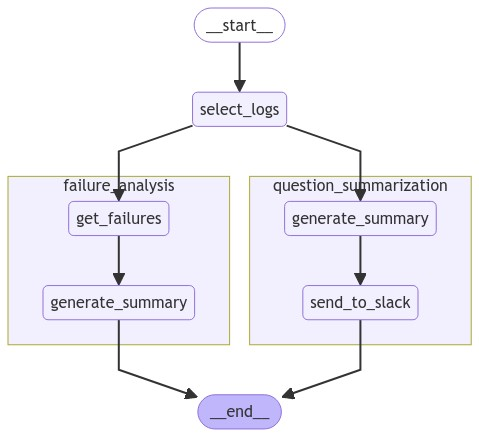

In [3]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[list[Logs], add_logs]
    logs: Annotated[list[Logs], add_logs]  # This will be used in subgraphs
    failure_report: str  # This will be generated in the FA subgraph
    summary_report: str  # This will be generated in the QS subgraph


def select_logs(state):
    return {"logs": [log for log in state["raw_logs"] if "grade" in log]}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("select_logs", select_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "select_logs")
entry_builder.add_edge("select_logs", "failure_analysis")
entry_builder.add_edge("select_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Stream

Now let's see how we can stream from our graph!

### Define input

First, let's define the input we will use for the rest of the notebook:

In [4]:
# Dummy logs
dummy_logs = [
    Logs(
        id="1",
        question="How can I import ChatOllama?",
        grade=1,
        answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
    ),
    Logs(
        id="2",
        question="How can I use Chroma vector store?",
        answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
        grade=0,
        feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
    ),
    Logs(
        id="3",
        question="How do I create react agent in langgraph?",
        answer="from langgraph.prebuilt import create_react_agent",
    )
]

input = {"raw_logs": dummy_logs}

### Stream normally

First let us examine the output of streaming normally:

In [5]:
for chunk in graph.stream(input, stream_mode="updates"):
    node_name = list(chunk.keys())[0]
    print(f"---------- Update from node {node_name} ---------")
    print(chunk[node_name])

---------- Update from node select_logs ---------
{'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}
---------- Update from node failure_analysis ---------
{'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not

As you can see there are only 3 updates made to our overall graph state. The first one is by the `select_logs` node, and then we receive one update from each subgraph (note if you don't want to see the `log` update from each subgraph that you can set the [output schema](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/) to exclude it). What we do not see however, is the updates occurring *inside* each subgraph. The next section will explain how to do that.

### Stream subgraph 

To show the updates occurring inside of each subgraph, we can simply set `subgraphs=True` to the streaming call:

In [12]:
# Format the namespace slightly nicer
def format_namespace(namespace):
    return namespace[-1].split(':')[0]+' subgraph' if len(namespace) > 0 else 'parent graph'

for namespace, chunk in graph.stream(input, stream_mode="updates", subgraphs=True):
    node_name = list(chunk.keys())[0]
    print(f"---------- Update from node {node_name} in {format_namespace(namespace)} ---------")
    print(chunk[node_name])

---------- Update from node select_logs in parent graph ---------
{'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}
---------- Update from node get_failures in failure_analysis subgraph ---------
{'failures': [{'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}
---------- Update from node generate_summary in failure_analysis subgraph ---------
{'failure_rep

The first thing you will notice as different is that we are no longer just receiving chunks, but we also receive namespaces which tell us what subgraph we are currently inside of.

If you look carefully at the logs you can see we are now receiving the updates made by nodes inside of each subgraph, for instance we now see updates to the `summary_report` state channel from the `get_failure` node which lives in the `failure_analysis` subgraph. When we didn't set `subgraphs=True` all we saw was the overall update made by the subgraph `failure_analysis`.